In [2]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=fd0e51bd5af131aeb2e1af70dae7a63689da49793927cb99db5daac0bf592e5a
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc



--- Teleporting state with theta=0.80, phi=0.30 ---
Initial state of qubit 0:


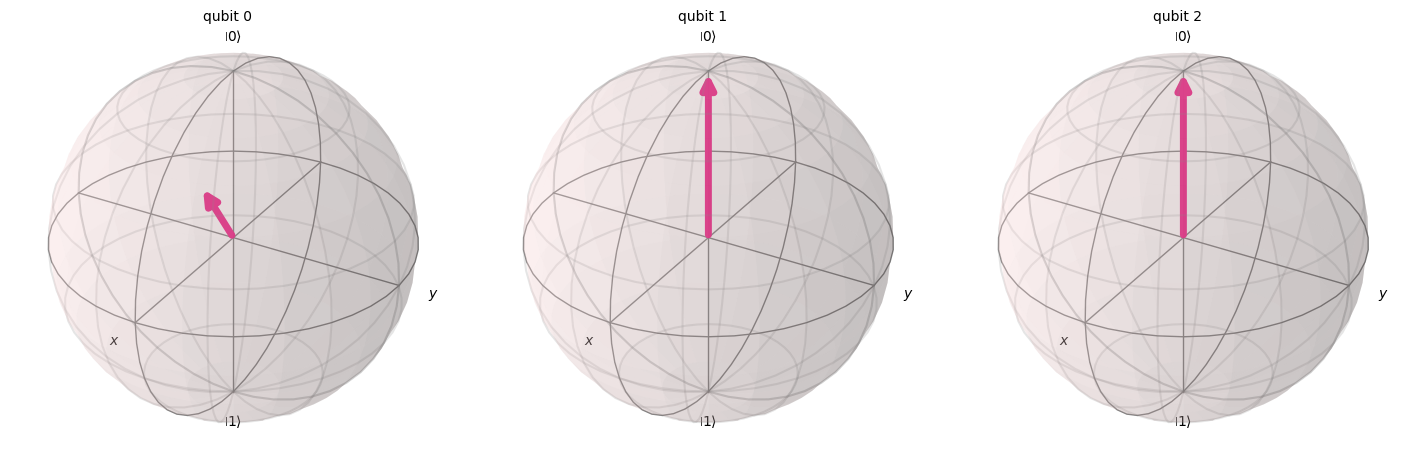

Fidelity between initial and teleported states: 1.000000

Bob’s final qubit (qubit 2) Bloch vector:


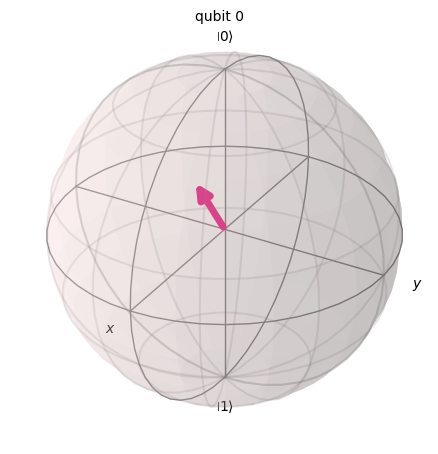


--- Teleporting state with theta=0.79, phi=1.57 ---
Initial state of qubit 0:


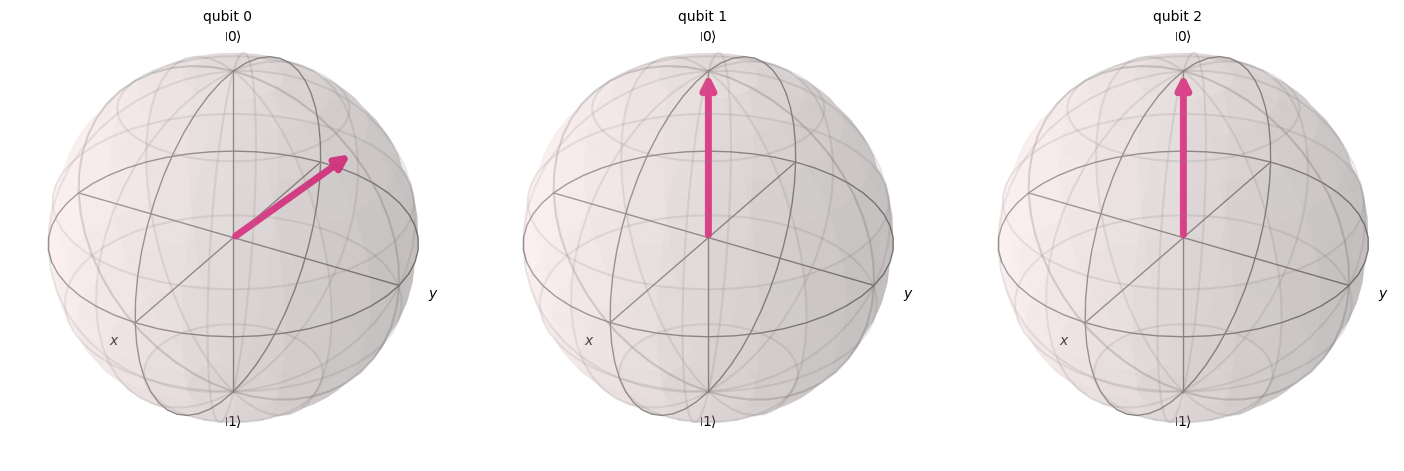

Fidelity between initial and teleported states: 1.000000

Bob’s final qubit (qubit 2) Bloch vector:


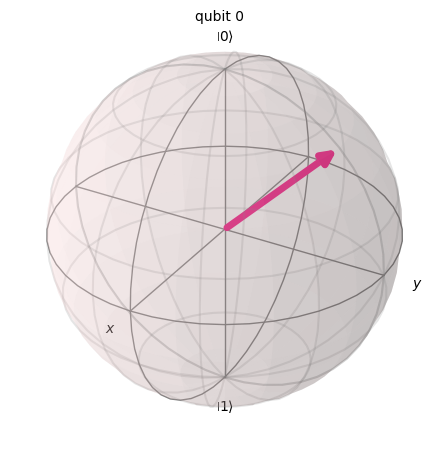


--- Teleporting state with theta=1.57, phi=0.00 ---
Initial state of qubit 0:


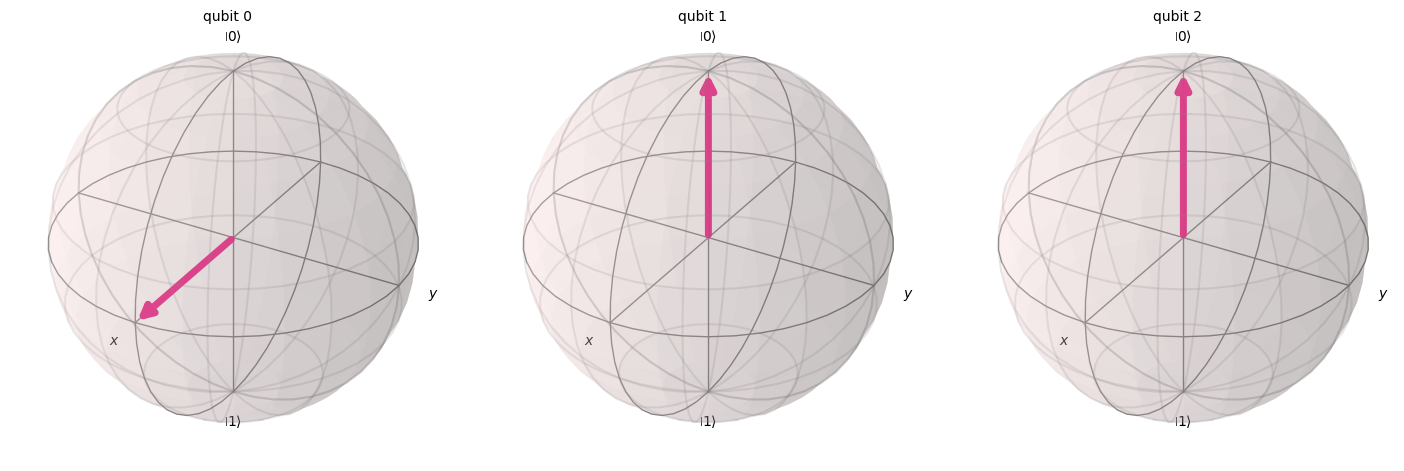

Fidelity between initial and teleported states: 1.000000

Bob’s final qubit (qubit 2) Bloch vector:


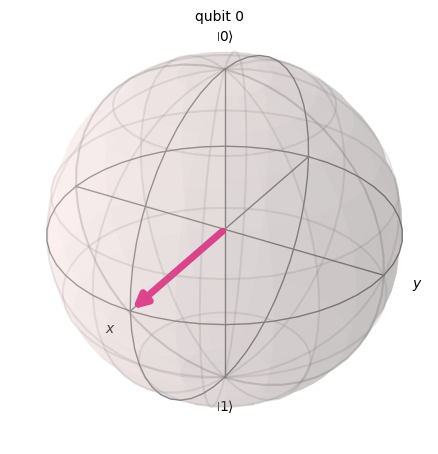


--- Teleporting state with theta=0.00, phi=3.14 ---
Initial state of qubit 0:


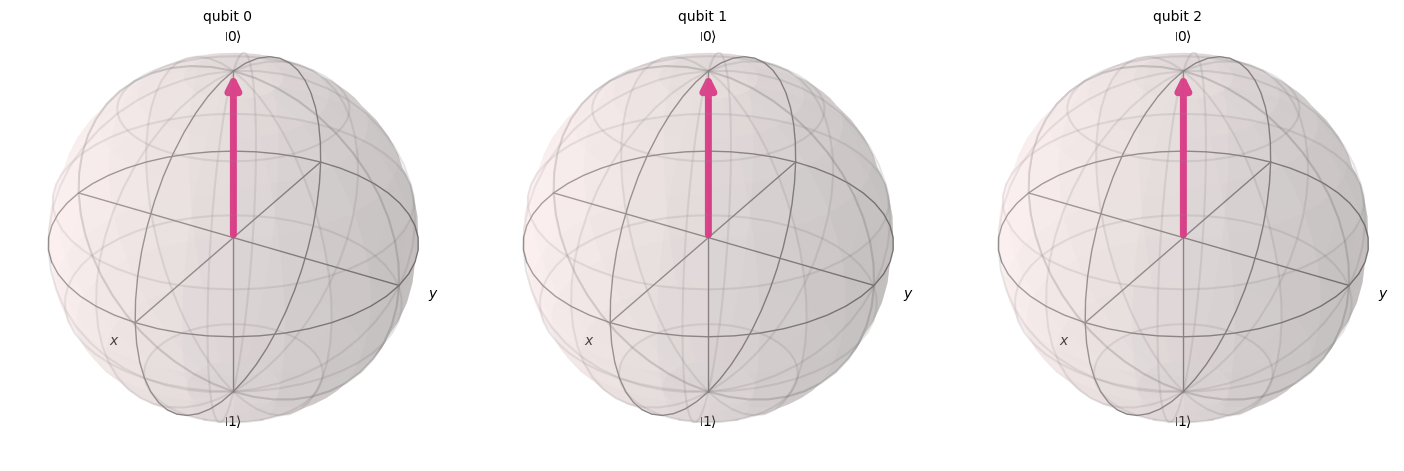

Fidelity between initial and teleported states: 1.000000

Bob’s final qubit (qubit 2) Bloch vector:


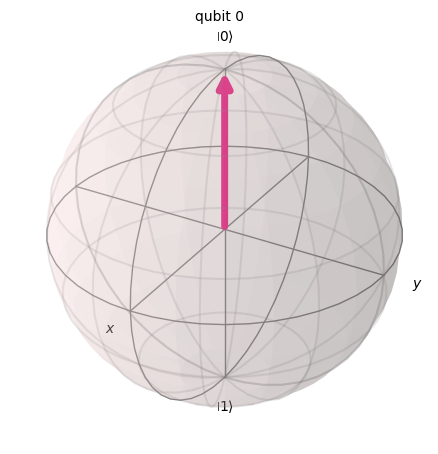

In [3]:
# Quantum Teleportation (Coherent version) – Qiskit 2.x compatible
# Works on modern qiskit-aer simulators

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

# Define different states to teleport
states_to_teleport = [
    {"theta": 0.8, "phi": 0.3},  # Original state
    {"theta": np.pi / 4, "phi": np.pi / 2},  # Example 1
    {"theta": np.pi / 2, "phi": 0},  # Example 2
    {"theta": 0, "phi": np.pi},  # Example 3
]

for state_params in states_to_teleport:
    theta = state_params["theta"]
    phi = state_params["phi"]

    print(f"\n--- Teleporting state with theta={theta:.2f}, phi={phi:.2f} ---")

    # 1️⃣ Build the teleportation circuit
    qc = QuantumCircuit(3)

    # Prepare arbitrary state |ψ⟩ on qubit 0
    qc.ry(theta, 0)
    qc.rz(phi, 0)

    # Save initial state for comparison
    sv_initial = Statevector.from_instruction(qc)
    print("Initial state of qubit 0:")
    display(plot_bloch_multivector(sv_initial))

    # Create Bell pair between qubits 1 and 2
    qc.h(1)
    qc.cx(1, 2)

    # Bell measurement part (but coherent)
    qc.cx(0, 1)
    qc.h(0)

    # Coherent corrections
    qc.cx(1, 2)
    qc.cz(0, 2)

    # Save final statevector explicitly (Qiskit 2.x requires this)
    qc.save_statevector()

    # 2️⃣ Simulate
    sim = AerSimulator()
    compiled = transpile(qc, sim)
    result = sim.run(compiled).result()

    # Retrieve the saved statevector
    sv_final = result.data(0)["statevector"]
    sv_final = Statevector(sv_final)

    # 3️⃣ Compare: initial vs Bob’s (qubit 2) final state
    rho_bob = partial_trace(sv_final, [0, 1])
    rho_init = partial_trace(sv_initial, [1, 2])

    # Extract the dominant pure states (since both should be pure)
    eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
    eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
    bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
    init_state = eigvecs_i[:, np.argmax(eigvals_i)]

    # Compute fidelity
    fidelity = np.abs(np.vdot(init_state, bob_state)) ** 2
    print(f"Fidelity between initial and teleported states: {fidelity:.6f}")

    # 4️⃣ Visualize Bloch spheres (fixed)
    print("\nBob’s final qubit (qubit 2) Bloch vector:")

    # Convert rho_bob (DensityMatrix) → pure statevector (dominant eigenvector)
    eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
    bob_state = eigvecs_b[:, np.argmax(eigvals_b)]  # dominant eigenvector
    bob_sv = Statevector(bob_state)

    display(plot_bloch_multivector(bob_sv))